# State Autoencoder

This notebook trains a Transformer autoencoder to reconstruct measurements. It projects the sequential input down to a latent variable, $z$, that should represent the state of the system.

In [64]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
import data.datautil as du

from models import TransformerEncoder, TransformerDecoder

In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loading the data

In [68]:
data_name='Rectifier_oct23_input_constant'
sim_name='RectifierData_step10h' 
dataset_name='RUL_real'

In [69]:
with open(f'./data/{data_name}/dataset_{dataset_name}_train.pkl', 'rb') as file:
    train_dataset = pickle.load(file)

In [70]:
with open(f'./data/{data_name}/dataset_{dataset_name}_test.pkl', 'rb') as file:
    test_dataset = pickle.load(file)

In [71]:
print(f'Dataset name: {train_dataset.dataset_name}') 
for var in train_dataset.n_var:
    if train_dataset.n_var[var]:
        print(f'Features ({var}): {train_dataset.labels[var]}')  
        print(f'-shape: {train_dataset.var[var].shape}')

if train_dataset.n_var['U']:
    simulation_size=train_dataset.origin['U'].shape[1]
    print(f'Simulation size: {simulation_size}') 
print(f'Number of systems: {train_dataset.n_sys}') 

Dataset name: RUL_real
Features (X): ['i1', 'i2', 'i3', 'I_DC']
-shape: (63255, 4)
Features (Y): ['RUL']
-shape: (63255, 1)
Number of systems: 200


In [72]:
batch_size = 128
stats = ['X']
timestep=9
window={'X':[timestep,0],'Y':[0,0]}
trainloader = du.create_loader(train_dataset, batch_size, stats, window=window, shuffle=True)
trainloader

In [73]:
batch_size = 128
stats = ['X']
timestep=9
window={'X':[timestep,0],'Y':[0,0]}
testloader = du.create_loader(test_dataset, batch_size, stats, window=window, shuffle=False)
testloader

In [74]:
ex_X, ex_y = next(iter(trainloader))
print(f"X Shape: {ex_X.shape}, Y Shape: {ex_y.shape}")

X Shape: torch.Size([128, 10, 4]), Y Shape: torch.Size([128, 1, 1])


In [75]:
ex_X.dtype

torch.float64

In [76]:
enc = TransformerEncoder(input_dim=ex_X.shape[2], embed_dim=2, dropout=0.1)
dec = TransformerDecoder(output_dim=ex_X.shape[2], embed_dim=2, dropout=0.1)

In [77]:
pred = enc(ex_X.to(torch.float32))

In [78]:
pred

tensor([[ 6.7950e-02,  2.6701e-01],
        [ 2.7360e-02,  1.4772e-01],
        [ 7.3791e-02,  2.0030e-01],
        [-7.8401e-02,  2.2621e-01],
        [ 7.2443e-02,  9.9626e-02],
        [-3.7942e-03,  1.1990e-01],
        [-1.8390e-02,  1.8262e-01],
        [-3.0194e-02,  1.6839e-01],
        [-3.7015e-02,  8.5704e-02],
        [ 4.7629e-02,  1.3494e-01],
        [ 4.6298e-02,  1.7568e-01],
        [-2.0069e-03,  9.4761e-02],
        [ 4.2374e-03,  1.8917e-01],
        [ 2.1071e-02,  8.7283e-02],
        [ 1.2576e-01,  9.4864e-02],
        [-6.4050e-02,  1.1114e-01],
        [-6.9754e-02,  1.6305e-01],
        [ 2.0421e-02,  1.1464e-01],
        [ 6.5032e-02,  1.8445e-01],
        [-2.3094e-02,  1.8639e-01],
        [ 1.0591e-01,  1.7176e-01],
        [ 8.3853e-03,  5.7033e-02],
        [ 1.7631e-02,  2.1312e-01],
        [ 3.5655e-02,  1.2091e-01],
        [ 1.8629e-02,  1.0185e-01],
        [ 9.3115e-02,  1.7939e-01],
        [ 1.0982e-01,  1.0043e-01],
        [-5.9577e-02,  1.884

In [79]:
torch.std(ex_X)

tensor(0.1332, dtype=torch.float64)

In [80]:
xhat = dec(pred)

In [81]:
def plot_latent_space(enc, dataloader):
    zs = []
    enc.eval()
    for X, y in tqdm(dataloader):
        X = X.to(torch.float32).to(device)
        z = enc(X)
        zs.append(z.detach().cpu().numpy())
    
    zs = np.vstack(zs)
    print(zs.shape)
    plt.scatter(zs[:,0], zs[:,1])
    plt.show()
    
    return zs

100%|██████████| 481/481 [00:00<00:00, 615.56it/s]


(61455, 2)


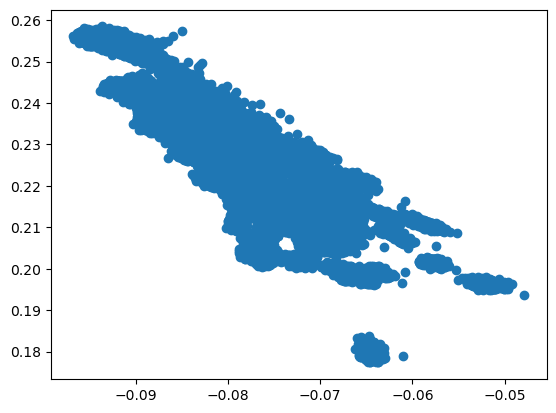

In [82]:
enc = TransformerEncoder(input_dim=ex_X.shape[2], embed_dim=2, dropout=0.1, device=device).to(device)
dec = TransformerDecoder(output_dim=ex_X.shape[2], embed_dim=2, dropout=0.1).to(device)
zs = plot_latent_space(enc, trainloader)

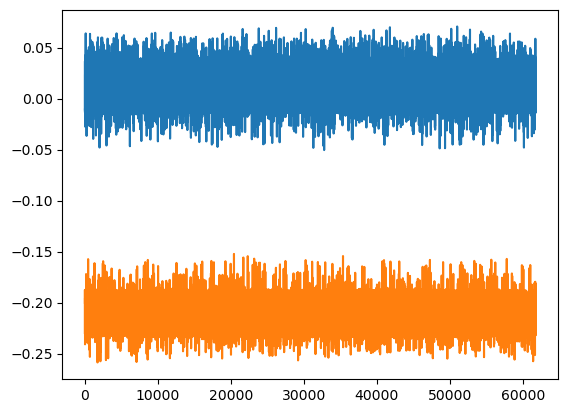

In [18]:
plt.plot(zs)

In [19]:
zs

array([[-0.01247328, -0.20008096],
       [-0.0115653 , -0.19940354],
       [-0.0097859 , -0.18747407],
       ...,
       [ 0.02604514, -0.22685207],
       [-0.00885804, -0.19070747],
       [ 0.02230499, -0.2097328 ]], dtype=float32)

In [95]:
enc = TransformerEncoder(input_dim=ex_X.shape[2], embed_dim=3, dropout=0.25, device=device).to(device)
dec = TransformerDecoder(output_dim=ex_X.shape[2], embed_dim=3, dropout=0.25).to(device)
objective = nn.MSELoss()
params = list(enc.parameters()) + list(dec.parameters())
    # optimizer
optim = torch.optim.Adam(params, lr=1e-4)

n_epochs = 5
losses = []
for i in tqdm(range(n_epochs)):
    for X, y in trainloader:
        optim.zero_grad()     
        X = X.to(torch.float32).to(device)
        y = y.to(device)
        
        z = enc(X)
        Xhat = dec(z)
        
        loss = objective(Xhat, X[:,-1,:])
        loss.backward()
        optim.step()
        
        losses.append(loss.item())
    # plot_latent_space(enc, trainloader)
    enc.train()
        
    print(f"Epoch: {i+1}, loss: {np.mean(losses[-100:])}")

 20%|██        | 1/5 [00:07<00:31,  7.89s/it]

Epoch: 1, loss: 0.018761294931173324


 40%|████      | 2/5 [00:15<00:23,  7.86s/it]

Epoch: 2, loss: 0.016686498522758483


 60%|██████    | 3/5 [00:23<00:15,  7.87s/it]

Epoch: 3, loss: 0.015564862033352255


 80%|████████  | 4/5 [00:31<00:07,  7.85s/it]

Epoch: 4, loss: 0.014920186987146734


100%|██████████| 5/5 [00:39<00:00,  7.84s/it]

Epoch: 5, loss: 0.014237768426537513


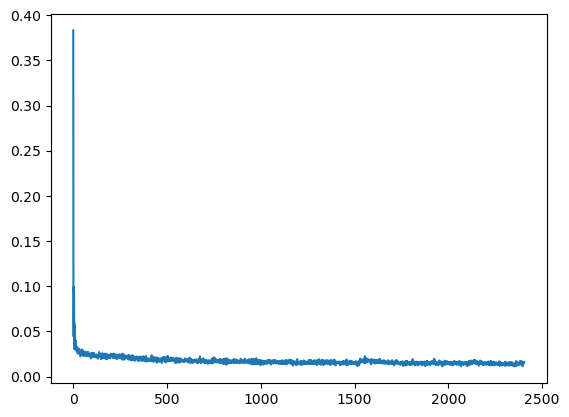

In [96]:
plt.plot(losses)

In [97]:
errors = []
zs = []
ruls = []
enc.eval()
dec.eval()
for X, y in tqdm(testloader):
    X = X.to(torch.float32).to(device)
    
    z = enc(X)
    Xhat = dec(z) 
    
    zs.append(z.detach().cpu().numpy())
    # print(Xhat.shape, X.shape)
    loss = objective(Xhat, X[:,-1,:])
    errors.append(loss.item())
    ruls.append(y.numpy())
    
ruls = np.concatenate(ruls).flatten()
zs = np.vstack(zs)
errors = np.array(errors)

100%|██████████| 121/121 [00:00<00:00, 409.89it/s]


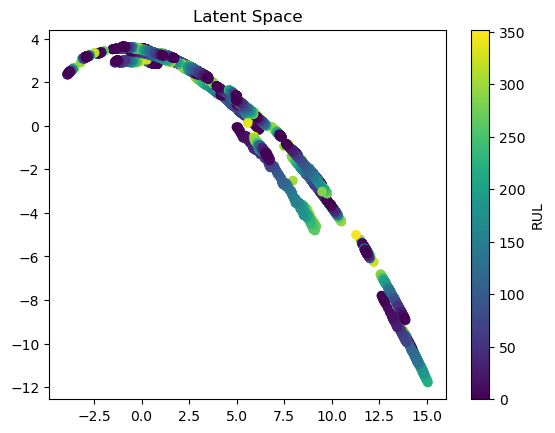

In [98]:
plt.title("Latent Space")
scatter = plt.scatter(zs[:,0], zs[:,1], c=ruls)
cbar = plt.colorbar(scatter)
cbar.set_label('RUL')  # Replace with an appropriate label

plt.show()

In [93]:
np.mean(errors)

0.027760661727641054

In [99]:
torch.save({
    'model_state_dict': enc.state_dict(),
    'positional_embed': enc.positional_embed.data            
}, './saved_models/const_enc_3dim.pth')
torch.save(dec.state_dict(), './saved_models/const_dec_3dim.pth')